# Explore resting state BOLD fMRI data (work in progress ...)

BMED360-2021  `03-resing-state-fmri-explore.ipynb`

(using selected datasets from the Brain-Gut BIDS collection) 

<a href="https://colab.research.google.com/github/computational-medicine/BMED360-2021/blob/main/Lab6-Networks-Graphs/03-resting-state-fmri-explore.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Learning objectives:


Three major topics


- #### The nature of 4D (3D+time) resting state BOLD fMRI data
See also: _What is meant by resting state fMRI? How is it used?_ in [[mriquestions.com](http://mriquestions.com/resting-state-fmri.html)] <br>
and Gili Karni's _Identifying Resting-State Networks from fMRI Data Using ICAs -
A hands-on tutorial: from data collection to feature extraction_ [[here](https://towardsdatascience.com/exploring-cognitive-differences-via-resting-state-networks-2112bf5291e2)] and [[here](https://github.com/karnigili/Computational-Neuroscience)]


- #### BIDS: Brain Imaging Data Structure
The Brain Imaging Data Structure (BIDS) is a standard prescribing a formal way to name and organize MRI data and metadata in a file system that simplifies communication and collaboration between users and enables easier data validation and software development through using consistent paths and naming for data files. (See: https://bids.neuroimaging.io and https://training.incf.org/lesson/introduction-brain-imaging-data-structure-bids).<br> We will be using `pybids` (https://github.com/bids-standard/pybids) (included by `pip install pybids` in the `environment.yml`file) to access the `./data/bids_bg_bmed360` information (e.g. `participants.tsv`)

- #### Open science with Open data (BIDS validated)
E.g. Explore the **OpenNeuro** collection:  https://openneuro.org/datasets/ds000030/versions/1.0.0 + https://f1000research.com/articles/6-1262/v2<br>
How to download such a large dataset (Files: 9010, Size: 79.28GB, Subjects: 272) using the AWS Command Line Interface (https://aws.amazon.com/cli). The `derivatives` are the preprocessed data using `fmriprep`.
```
aws s3 sync --no-sign-request s3://openneuro.org/ds000030 ds000030-download/
aws s3 sync --no-sign-request s3://openneuro/ds000030/ds000030_R1.0.5/uncompressed/derivatives/ ds000030-derivatives-download/
```
Bilder, R and Poldrack, R and Cannon, T and London, E and Freimer, N and Congdon, E and Karlsgodt, K and Sabb, F (2020). UCLA Consortium for Neuropsychiatric Phenomics LA5c Study. OpenNeuro. [Dataset] doi: 10.18112/openneuro.ds000030.v1.0.0

### Some instructive videos on resting state fMRI and the BIDS - Brain Imaging Data Structure

In [1]:
%%HTML
<iframe width="560" height="315" src="https://www.youtube.com/embed/1A76JgNrEqI" 
frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen>
</iframe>

In [2]:
%%HTML
<iframe width="560" height="315" src="https://www.youtube.com/embed/DavxePlS94w" 
frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen>
</iframe>

In [3]:
%%HTML
<iframe width="560" height="315" src="https://www.youtube.com/embed/kxj0PLyzYsg" 
frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen>
</iframe>

## Setup

In [4]:
# Set this to True if you are using Colab:
colab=False

#### For using Google Colab
**--> (some of) the following libraries must be `pip installed`):**

In [5]:
if colab:
    !pip install gdown
    !pip install nibabel
    !pip install pybids
    !pip install nilearn

In [6]:
# We will be using pybids in our bmed360 environment, if not already installed: uncomment the following
#!pip install pybids

### Set up libraries and folders

In [7]:
import gdown
import shutil
import sys
import os
from os.path import expanduser, join, basename, split
import glob
import shutil
import platform
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import bids
from nilearn import datasets, plotting, image
import warnings

%matplotlib inline
warnings.filterwarnings("ignore")

/Users/arvid/opt/anaconda3/envs/bmed360/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [8]:
cwd = os.getcwd()

In [9]:
working_dir = join(cwd, 'data')
bids_dir = '%s/bids_bg_bmed360' % (working_dir)
openneuro_dir = '%s/OpenNeuro' % (working_dir)
assets_dir =  join(cwd, 'assets')
sol_dir =  join(cwd, 'solutions')

Check your platform for running this notebook

In [10]:
if platform.system() == 'Darwin':
    print(f'OK, you are running on MacOS ({platform.version()})')
if platform.system() == 'Linux':
    print(f'OK, you are running on Linux ({platform.version()})')
if platform.system() == 'Windows':
    print(f'OK, but consider to install WSL for Windows10 since you are running on {platform.system()}')
    print('Check https://docs.microsoft.com/en-us/windows/wsl/install-win10')

OK, you are running on MacOS (Darwin Kernel Version 20.4.0: Thu Apr 22 21:46:47 PDT 2021; root:xnu-7195.101.2~1/RELEASE_X86_64)


### Download the data

**Download a files (not on GitHub repository) from Google Drive using gdown** (https://github.com/wkentaro/gdown)

In [11]:
# Download zip-file if ./data does not exist (as when running in Colab)

if os.path.isdir(working_dir) == False:
    
    ## Download data.zip for Google Drive             
    #https://drive.google.com/file/d/1CSIUGSYAplD2mxjuidVkfbXrPzoyjFNi/view?usp=sharing
    file_id = '1CSIUGSYAplD2mxjuidVkfbXrPzoyjFNi'
    url = 'https://drive.google.com/uc?id=%s' % file_id
    output = './data.zip'
    gdown.download(url, output, quiet=False)
    
    ## Unzip the assets file into `./data`
    shutil.unpack_archive(output, '.')
    
    ## Delete the `data.zip` file
    os.remove(output)
else:
    print(f'./data  exists already!')

./data  exists already!


In [12]:
# Download zip-file if ./assets does not exist (as when running in Colab)

if os.path.isdir(assets_dir) == False:
    
    ## Download assets.zip for Google Drive            
    # https://drive.google.com/file/d/1tRcRTxNT8nwNFrmGYJqo1B8WgGJ2yEgq/view?usp=sharing
    file_id = '1tRcRTxNT8nwNFrmGYJqo1B8WgGJ2yEgq'
    url = 'https://drive.google.com/uc?id=%s' % file_id
    output = 'assets.zip'
    gdown.download(url, output, quiet=False)
    
    ## Unzip the assets file into `./assets`
    shutil.unpack_archive(output, '.')
    
    ## Delete the `assets.zip` file
    os.remove(output)
else:
    print(f'./assets  exists already!')

./assets  exists already!


In [13]:
# Download zip-file if ./solutions does not exist (as when running in Colab)

if os.path.isdir(sol_dir) == False:
    
    ## Download assets.zip for Google Drive            
    # https://drive.google.com/file/d/16MuT-pshT473eADdqhFr_dmb-4QPGt4r/view?usp=sharing
    file_id = '16MuT-pshT473eADdqhFr_dmb-4QPGt4r'
    url = 'https://drive.google.com/uc?id=%s' % file_id
    output = 'solutions.zip'
    gdown.download(url, output, quiet=False)
    
    ## Unzip the assets file into `./solutions`
    shutil.unpack_archive(output, '.')
    
    ## Delete the `solutions.zip` file
    os.remove(output)
else:
    print(f'./solutions  exists already!')

./solutions  exists already!


# BIDS: Brain Imaging Dataset Specification

Recently, there has been growing interest to share datasets across labs and even on public repositories such as [openneuro](https://openneuro.org/). In order to make this a succesful enterprise, it is necessary to have some standards in how the data are named and organized. Historically, each lab has used their own idiosyncratic conventions, which can make it difficult for outsiders to analyze. In the past few years, there have been heroic efforts by the neuroimaging community to create a standardized file organization and naming practices. This specification is called **BIDS** for [Brain Imaging Dataset Specification](http://bids.neuroimaging.io/).

As you can imagine, individuals have their own distinct method of organizing their files. Think about how you keep track of your files on your personal laptop (versus your friend). This may be okay in the personal realm, but in science, it's best if anyone (especially  yourself 6 months from now!) can follow your work and know *which* files mean *what* by their titles.

Here's an example of non-Bids versus BIDS dataset found in [this paper](https://www.nature.com/articles/sdata201644):

![file_tree](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fsdata.2016.44/MediaObjects/41597_2016_Article_BFsdata201644_Fig1_HTML.jpg?as=webp)

Here are a few major differences between the two datasets:

1. In BIDS, files are in nifti format (not dicoms).
2. In BIDS, scans are broken up into separate folders by type of scan(functional versus anatomical versus diffusion weighted) for each subject.
3. In BIDS, JSON files are included that contain descriptive information about the scans (e.g., acquisition parameters)

Not only can using this specification be useful within labs to have a set way of structuring data, but it can also be useful when collaborating across labs, developing and utilizing software, and publishing data.

In addition, because this is a consistent format, it is possible to have a python package to make it easy to query a dataset. We recommend using [pybids](https://github.com/bids-standard/pybids).

The dataset we will be working with has already been converted to the BIDS format (see download localizer tutorial). 

You may need to install [pybids]() to query the BIDS datasets using following command `!pip install pybids` (in colab), or<br>
`conda install -c aramislab pybids` (old version 0.5.1 !) in the `bmed360` conda environment.

## The `BIDSLayout`
[Pybids](https://github.com/bids-standard/pybids) is a package to help query and navigate a neurogimaging dataset that is in the BIDs format. At the core of pybids is the `BIDSLayout` object. A `BIDSLayout` is a lightweight Python class that represents a BIDS project file tree and provides a variety of helpful methods for querying and manipulating BIDS files. While the BIDSLayout initializer has a large number of arguments you can use to control the way files are indexed and accessed, you will most commonly initialize a BIDSLayout by passing in the BIDS dataset root location as a single argument.

Notice we are setting `derivatives=True`. This means the layout will also index the derivatives sub folder, which might contain preprocessed data, analyses, or other user generated files. 

In [14]:
from bids import BIDSLayout, BIDSValidator

#bids.config.set_option('extension_initial_dot', True)

data_dir = bids_dir
layout = BIDSLayout(data_dir, derivatives=False)
layout

BIDS Layout: ...ks-Graphs/data/bids_bg_bmed360 | Subjects: 4 | Sessions: 8 | Runs: 0

When we initialize a BIDSLayout, all of the files and metadata found under the specified root folder are indexed. This can take a few seconds (or, for very large datasets, a minute or two). Once initialization is complete, we can start querying the BIDSLayout in various ways. The main query method is `.get()`. If we call .`get()` with no additional arguments, we get back a list of all the BIDS files in our dataset.

Let's return the first 10 files

In [15]:
layout.get()[:10]

[<BIDSJSONFile filename='/Users/arvid/GitHub/computational-medicine/BMED360-2021/Lab6-Networks-Graphs/data/bids_bg_bmed360/dataset_description.json'>,
 <BIDSJSONFile filename='/Users/arvid/GitHub/computational-medicine/BMED360-2021/Lab6-Networks-Graphs/data/bids_bg_bmed360/participants.json'>,
 <BIDSDataFile filename='/Users/arvid/GitHub/computational-medicine/BMED360-2021/Lab6-Networks-Graphs/data/bids_bg_bmed360/participants.tsv'>,
 <BIDSFile filename='/Users/arvid/GitHub/computational-medicine/BMED360-2021/Lab6-Networks-Graphs/data/bids_bg_bmed360/README'>,
 <BIDSJSONFile filename='/Users/arvid/GitHub/computational-medicine/BMED360-2021/Lab6-Networks-Graphs/data/bids_bg_bmed360/sub-102/ses-1/anat/sub-102_ses-1_T1w.json'>,
 <BIDSImageFile filename='/Users/arvid/GitHub/computational-medicine/BMED360-2021/Lab6-Networks-Graphs/data/bids_bg_bmed360/sub-102/ses-1/anat/sub-102_ses-1_T1w.nii.gz'>,
 <BIDSFile filename='/Users/arvid/GitHub/computational-medicine/BMED360-2021/Lab6-Networks-Gra

When you call .get() on a BIDSLayout, the default returned values are objects of class BIDSFile. A BIDSFile is a lightweight container for individual files in a BIDS dataset. 

Here are some of the attributes and methods available to us in a BIDSFile (note that some of these are only available for certain subclasses of BIDSFile; e.g., you can't call get_image() on a BIDSFile that doesn't correspond to an image file!):

- .path: The full path of the associated file
- .filename: The associated file's filename (without directory)
- .dirname: The directory containing the file
- .get_entities(): Returns information about entities associated with this BIDSFile (optionally including metadata)
- .get_image(): Returns the file contents as a nibabel image (only works for image files)
- .get_df(): Get file contents as a pandas DataFrame (only works for TSV files)
- .get_metadata(): Returns a dictionary of all metadata found in associated JSON files
- .get_associations(): Returns a list of all files associated with this one in some way

Let's explore the first file in a little more detail.

In [16]:
f = layout.get()[0]
f

<BIDSJSONFile filename='/Users/arvid/GitHub/computational-medicine/BMED360-2021/Lab6-Networks-Graphs/data/bids_bg_bmed360/dataset_description.json'>

If you want a summary of all the files in your BIDSLayout, but don't want to have to iterate BIDSFile objects and extract their entities, you can get a nice bird's-eye view of your dataset using the `to_df()` method.

In [17]:
layout.to_df().head()

entity,path,datatype,extension,session,subject,suffix,task
0,/Users/arvid/GitHub/computational-medicine/BME...,NaN,json,NaN,NaN,description,NaN
1,/Users/arvid/GitHub/computational-medicine/BME...,NaN,json,NaN,NaN,participants,NaN
2,/Users/arvid/GitHub/computational-medicine/BME...,NaN,tsv,NaN,NaN,participants,NaN
3,/Users/arvid/GitHub/computational-medicine/BME...,anat,json,1,102,T1w,NaN
4,/Users/arvid/GitHub/computational-medicine/BME...,anat,nii.gz,1,102,T1w,NaN


In [18]:
layout.description

{'Name': 'Brain-Gut-Microbiota',
 'BIDSVersion': '1.6',
 'License': 'MIT',
 'Authors': ['E. Valestrand',
  'B. Bertelsen',
  'T. Hausken',
  'A. Lundervold',
  ' et al.'],
 'Acknowledgements': '',
 'HowToAcknowledge': '',
 'Funding': ['NFR FRIMEDBIO',
  'Helse-Vest',
  'Trond Mohn Foundation / MMIV',
  ''],
 'ReferencesAndLinks': ['https://braingut.no', '', ''],
 'DatasetDOI': '',
 'TaskName': 'rest'}

In [19]:
layout.entities

{'subject': <bids.layout.models.Entity at 0x7f8c5899dcd0>,
 'session': <bids.layout.models.Entity at 0x7f8c58b52cd0>,
 'task': <bids.layout.models.Entity at 0x7f8bf85d19d0>,
 'acquisition': <bids.layout.models.Entity at 0x7f8bf85d1a30>,
 'ceagent': <bids.layout.models.Entity at 0x7f8bf85d1a90>,
 'reconstruction': <bids.layout.models.Entity at 0x7f8bf85d1af0>,
 'direction': <bids.layout.models.Entity at 0x7f8bf85d1b50>,
 'run': <bids.layout.models.Entity at 0x7f8bf85d1bb0>,
 'proc': <bids.layout.models.Entity at 0x7f8bf85d1c10>,
 'modality': <bids.layout.models.Entity at 0x7f8bf85d1c70>,
 'echo': <bids.layout.models.Entity at 0x7f8bf85d1cd0>,
 'flip': <bids.layout.models.Entity at 0x7f8bf85d1d30>,
 'inv': <bids.layout.models.Entity at 0x7f8bf85d1d90>,
 'mt': <bids.layout.models.Entity at 0x7f8bf85d1df0>,
 'part': <bids.layout.models.Entity at 0x7f8bf85d1e50>,
 'recording': <bids.layout.models.Entity at 0x7f8bf85d1eb0>,
 'space': <bids.layout.models.Entity at 0x7f8bf85d1f10>,
 'suffix': 

In [20]:
layout.get_subjects()

['102', '103', '111', '123']

In [21]:
layout.get_sessions()

['1', '2']

In [22]:
layout.get_tasks()

['rest']

In [23]:
f = layout.get(extension='tsv')[0].filename
f

'participants.tsv'

In [24]:
fpath = layout.get(extension='tsv')[0].path
fpath

'/Users/arvid/GitHub/computational-medicine/BMED360-2021/Lab6-Networks-Graphs/data/bids_bg_bmed360/participants.tsv'

In [25]:
# df = pd.read_csv(fpath, sep='\t')  , or
df = pd.read_table(fpath)
df.T

,0,1,2,3
participant_id,sub-102,sub-103,sub-111,sub-123
gender,M,F,M,F
age,30,25,40,25
group,HC,HC,IBS,IBS
pre_soup_pain,1,1,2,15
pre_soup_nausea,1,2,2,0
pre_soup_fullnes,1,2,1,0
pre_soup_total,0,2,1,0
pre_soup_full,0,2,1,0
post_soup_pain,1,1,10,15


## Let's have a look at our fMRI data

First, a few handy functions:

In [26]:
def load_image(path):
    # load an img file
    return nib.load(path)

def get_TR(img):
    # retrieve TR data
    return img.header.get_zooms()[-1]

def get_slices(img):
    # retrieve number of slices
    return img.shape[2]
  
def get_header(img):
    # print the full header
    return(img.header)

In [27]:
sub = 102
ses = 1

path = '%s/sub-%d/ses-%d/func/sub-%d_ses-%d_task-rest_bold.nii.gz' % (bids_dir, sub, ses, sub, ses)

img = load_image(path)
data = img.get_fdata()
header=get_header(img)
TR = get_TR(img)
slices = get_slices(img)

print('TR: {}'.format(TR))
print('# of slices: {}'.format(slices))
print('dim:', img.header['dim'])
print('pixdim:', img.header['pixdim'])
print('data.shape:', data.shape)
print('\n', header)

TR: 2.0
# of slices: 26
dim: [  4 128 128  26 240   1   1   1]
pixdim: [-1.      1.7188  1.7188  3.5     2.      0.      0.      0.    ]
data.shape: (128, 128, 26, 240)

 <class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b'fMRI_111005_suppe_'
extents         : 16384
session_error   : 0
regular         : b'r'
dim_info        : 121
dim             : [  4 128 128  26 240   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.      1.7188  1.7188  3.5     2.      0.      0.      0.    ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 25
slice_code      : alternating decreasing
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0769
toffset         : 0.0
glmax           : 7998
glmin           : 0
descrip         : b'phase=

### Plot an image representation of voxel intensities across time<br>
Power, J. D. A simple but useful way to assess fMRI scan qualities. Neuroimage 2017;154:150-158  [[link](https://doi.org/10.1016/j.neuroimage.2016.08.009)]

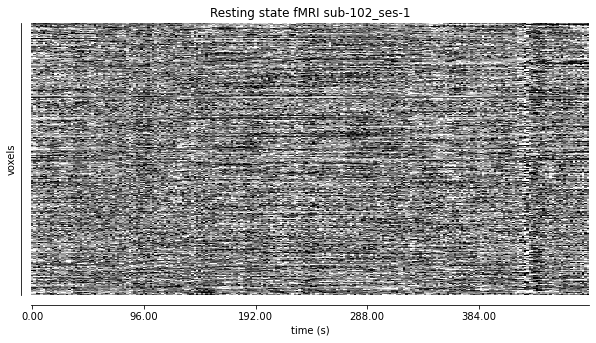

In [28]:
fig = plotting.plot_carpet(img,title=f'Resting state fMRI sub-{sub}_ses-{ses}')

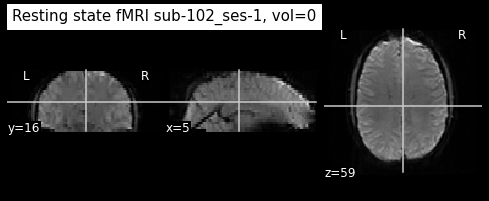

In [29]:
volno = 0
plotting.plot_epi(image.index_img(img, 0), \
                  cmap='gray',title=f'Resting state fMRI sub-{sub}_ses-{ses}, vol={volno}')
plt.show()

# Feature extraction using ICA from resting state networks 

(Using preprocessed data with `fmriprep` from HC subject `sub-10228` in the OpenNeuro collection [ds000030](https://openneuro.org/datasets/ds000030/versions/1.0.0))

Adopted from **Gili Karni**, Princeton University:<br> https://github.com/karnigili/Computational-Neuroscience/blob/master/rs_fmri_networks_ICA.ipynb  (MIT License)

In [30]:
# OLD: path='%s/sub-10228_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz' % (openneuro_dir)
path='%s/fmriprep/sub-10228/func/sub-10228_task-rest_bold_space-MNI152NLin2009cAsym_preproc.nii.gz' % (openneuro_dir)

img = load_image(path)
data = img.get_fdata()
TR = get_TR(img)
slices = get_slices(img)
    
print('TR: {}'.format(TR))
print('# of slices: {}'.format(slices))
print('data.shape:', data.shape)

TR: 2.0
# of slices: 49
data.shape: (65, 77, 49, 152)


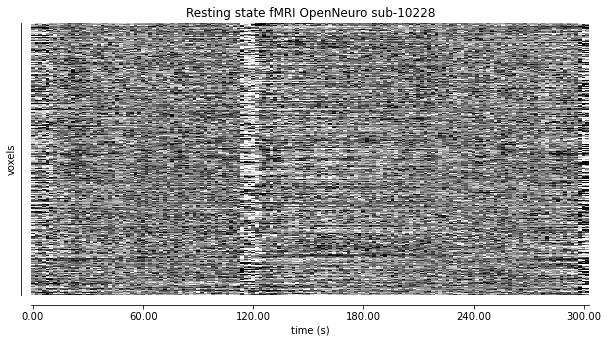

In [31]:
fig = plotting.plot_carpet(img,title=f'Resting state fMRI OpenNeuro sub-10228')

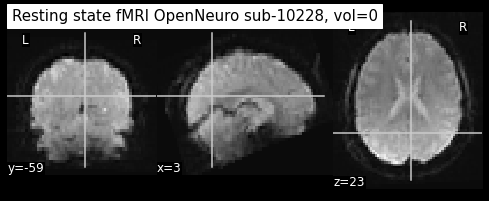

In [32]:
volno = 0
plotting.plot_epi(image.index_img(img, 0), \
                  cmap='gray',title=f'Resting state fMRI OpenNeuro sub-10228, vol={volno}')
plt.show()

## Feature extraction using ICA from resting state networks

In [33]:
from nilearn import input_data
from nilearn import datasets
from nilearn import plotting
from nilearn.plotting import plot_prob_atlas, plot_roi, plot_matrix

from nilearn.decomposition import CanICA 
from nilearn import image
from nilearn.regions import RegionExtractor


from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure

correlation_measure = ConnectivityMeasure(kind='correlation')

In [34]:
## create masker based on the atlas 
## and create a time series of the uploaded image using the masker
def create_mask(atlas_img, fmri_img):
  # generates a mask given img and atlas
  masker=NiftiLabelsMasker(labels_img=atlas_img, standardize=True)
  time_series=masker.fit_transform(fmri_img)
  
  return time_series

# using the correlation measures defined above, 
# we calculate the correaltion matrixes
def calc_correlation_matrix(time_series):
  # given a time series, return a correlation matrix
  # we regress out the confounds (as found in the 
  # preprocessing stage)
  return correlation_measure.fit_transform([time_series])[0]

#and we plot,
def plot_cor_matrix(correlation_matrix, title, labels=None):
  ## plot the correlation matrix
  
    
  np.fill_diagonal(correlation_matrix, 0)
  if labels:
    plot_matrix(correlation_matrix, figure=(10, 8), 
              labels=labels,
                       vmax=0.8, vmin=-0.8, reorder=True)
  else:
    plot_matrix(correlation_matrix, figure=(10, 8), 
              labels=range(correlation_matrix.shape[1]),
                       vmax=0.8, vmin=-0.8, reorder=True)
  plt.title(title)
  plt.show()

## Preparing for atlas-based analysis

We include two types of atlases. The first is the Harvard-Oxford probabilistic atlas (Makris et al., 2006; Frazier et al., 2005; Desikan et al., 2006; Goldstein et al., 2007) and the second is Smith's ICA functional map (Smith et al., 2009).

The Harvard-Oxford atals is based on MNI defined regions and the Smith's atlas reflecs regions resulting from an independent analyses of resting and activation brain dynamics.

Smith's includes 10 resting-state networks (rsns)

In [35]:
## import an existing map

# Harvard-Oxford
'''
retrived from https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/Atlases
'''
harvard_dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
harvard_maps = harvard_dataset.maps
harvard_labels = harvard_dataset.labels


Dataset created in /Users/arvid/nilearn_data/fsl



Downloaded 25698304 of 25716861 bytes (99.9%,    0.1s remaining) ...done. (113 seconds, 1 min)
Extracting data from /Users/arvid/nilearn_data/fsl/245b1ae3f43e3ea47e2ed9f438694f4a/HarvardOxford.tgz..... done.


In [36]:
## load the smith (ICA based) mask
## 'rsn10': 10 ICA maps from the above that matched across task and rest
# http://brainmap.org/pubs/SmithPNAS09.pdf

smith_atlas = datasets.fetch_atlas_smith_2009()
smith_atlas_rs_networks = smith_atlas.rsn10



Dataset created in /Users/arvid/nilearn_data/smith_2009



Downloaded 14573568 of 15129514 bytes (96.3%,    1.3s remaining) ...done. (37 seconds, 0 min)


Downloaded 6856704 of 7565016 bytes (90.6%,    1.7s remaining) ...done. (17 seconds, 0 min)


Downloaded 52551680 of 53028809 bytes (99.1%,    1.2s remaining) ...done. (134 seconds, 2 min)


Downloaded 19046400 of 19114114 bytes (99.6%,    0.2s remaining) ...done. (55 seconds, 0 min)


Downloaded 9560064 of 9566632 bytes (99.9%,    0.0s remaining) ...done. (27 seconds, 0 min)


Downloaded 66789376 of 67017538 bytes (99.7%,    0.6s remaining) ...done. (167 seconds, 2 min)


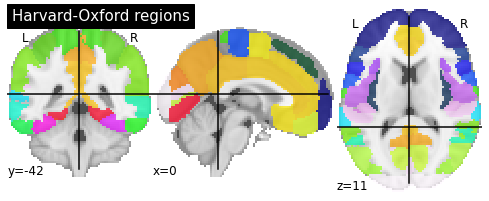

In [37]:
# plot the ROIs based on the map chosen
plot_roi(harvard_maps, title='Harvard-Oxford regions')
plt.show()

In [40]:
%%time
extraction = RegionExtractor(smith_atlas_rs_networks, min_region_size=800,
                             threshold=98, thresholding_strategy='percentile')

# Just call fit() to execute region extraction procedure
extraction.fit()
smith_maps = extraction.regions_img_

CPU times: user 25min 36s, sys: 20.9 s, total: 25min 57s
Wall time: 1min 40s


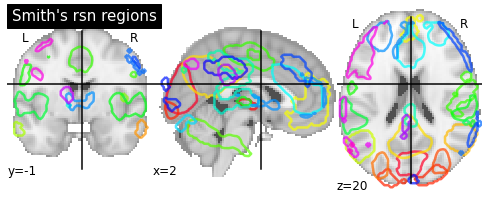

In [41]:
plotting.plot_prob_atlas(smith_maps, title="Smith's rsn regions")
plt.show()

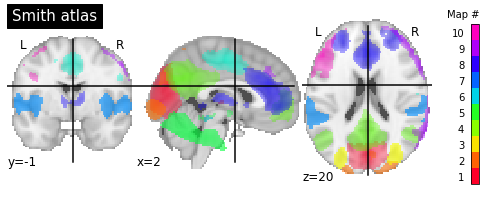

In [42]:
plotting.plot_prob_atlas(smith_atlas_rs_networks,
                         title='Smith atlas',  
                         colorbar=True)
plotting.show()

In [43]:
# An example for correlation matrix using both atlases


# Smith
# We take the first out of the 10 rsns
smith_1st_rsn=image.index_img(smith_atlas_rs_networks, 0)

In [44]:
smith_time_series=create_mask(smith_1st_rsn, img)

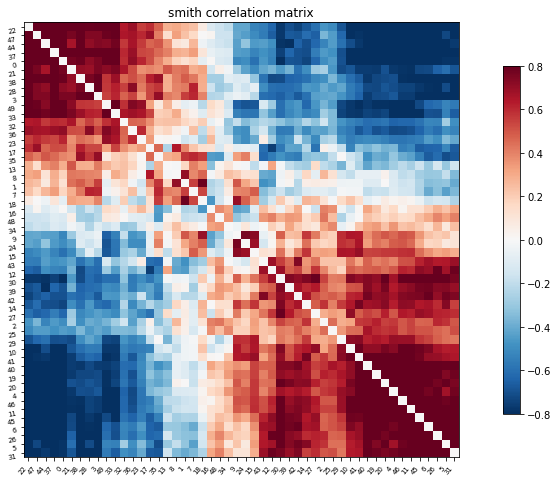

In [45]:
smith_time_series=create_mask(smith_1st_rsn, img)
cropped_smith_time_series=np.array([e[:50] for e in smith_time_series])
smith_cor_matrix=calc_correlation_matrix(cropped_smith_time_series)
plot_cor_matrix(smith_cor_matrix, 'smith correlation matrix')

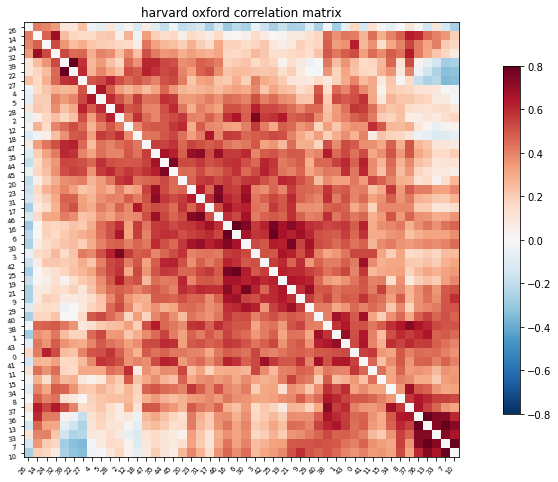

In [46]:
## plot the correlation matrix
# Harvard Oxford
harvard_oxford_time_series=create_mask(harvard_maps, img)
harvard_oxford_cor_matrix=calc_correlation_matrix(harvard_oxford_time_series)
plot_cor_matrix(harvard_oxford_cor_matrix, 'harvard oxford correlation matrix')


### ICA analysis (Varoquaux et al., 2010)

In [47]:
# perform an ICA given the subset of the data. 
ica = CanICA(n_components=20,
                random_state=0)

ica.fit(img)

CanICA(random_state=0)

In [48]:
ica.components_.shape

(20, 44591)

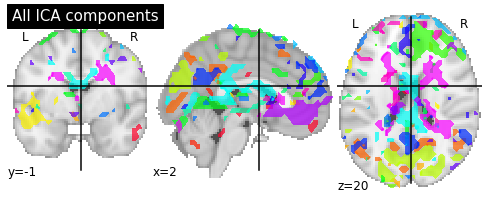

In [49]:
# exctract a 3D representation of the componenets and plot
components_img=ica.components_img_
plot_prob_atlas(components_img, title='All ICA components')
plt.show()

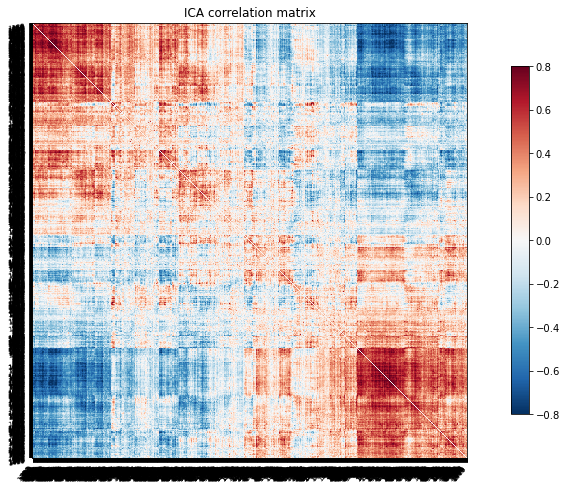

CPU times: user 42.3 s, sys: 1.03 s, total: 43.3 s
Wall time: 36.4 s


In [50]:
%%time
# ICA
components_img_1st=image.index_img(components_img, 0)
ica_time_series=create_mask(components_img_1st, img)
ica_cor_matrix=calc_correlation_matrix(ica_time_series)
plot_cor_matrix(ica_cor_matrix, 'ICA correlation matrix')

In [56]:
ica_time_series.data.shape

(152, 1929)


Varoquaux G. et al. “A group model for stable multi-subject ICA on fMRI datasets”, NeuroImage Vol 51 (2010), p. 288-299

Makris N, Goldstein JM, Kennedy D, Hodge SM, Caviness VS, Faraone SV, Tsuang MT, Seidman LJ. Decreased volume of left and total anterior insular lobule in schizophrenia. Schizophr Res. 2006 Apr;83(2-3):155-71

Frazier JA, Chiu S, Breeze JL, Makris N, Lange N, Kennedy DN, Herbert MR, Bent EK, Koneru VK, Dieterich ME, Hodge SM, Rauch SL, Grant PE, Cohen BM, Seidman LJ, Caviness VS, Biederman J. Structural brain magnetic resonance imaging of limbic and thalamic volumes in pediatric bipolar disorder. Am J Psychiatry. 2005 Jul;162(7):1256-65

Desikan RS, Ségonne F, Fischl B, Quinn BT, Dickerson BC, Blacker D, Buckner RL, Dale AM, Maguire RP, Hyman BT, Albert MS, Killiany RJ. An automated labeling system for subdividing the human cerebral cortex on MRI scans into gyral based regions of interest. Neuroimage. 2006 Jul 1;31(3):968-80.

Goldstein JM, Seidman LJ, Makris N, Ahern T, O'Brien LM, Caviness VS Jr, Kennedy DN, Faraone SV, Tsuang MT. Hypothalamic abnormalities in schizophrenia: sex effects and genetic vulnerability. Biol Psychiatry. 2007 Apr 15;61(8):935-45

Smith SM, Fox PT, Miller KL, Glahn DC, Fox PM, Mackay CE, Filippini N, Watkins KE, Toro R, Laird AR, and Beckmann CF. 2009. Correspondence of the brain’s functional architecture during activation and rest. Proc Natl Acad Sci USA (PNAS), 106(31):13040-13045. [[link](https://www.pnas.org/content/106/31/13040)]